# DataSets

## Sectors Dataset

El orden está en https://www.tradingview.com/markets/indices/quotes-snp/

La referencia de los códigos está en https://www.spglobal.com/marketintelligence/en/documents/112727-gics-mapbook_2018_v3_letter_digitalspreads.pdf

El sector de energía (^SP500-10) en Yahoo Finance se llama ^GSPE

In [73]:
import yfinance as yf
import pandas as pd
import numpy as np
import bs4 as bs
import requests
import lxml
import missingno

### Análisis de datos faltantes

In [74]:
# TAMBIÉN ESTA EL DE REAL STATE (^SP500-60) PERO ESE NO LO METE REFFINOT
selected_stocks = ['^GSPE', '^SP500-15','^SP500-20','^SP500-25','^SP500-30','^SP500-35','^SP500-40','^SP500-45','^SP500-50','^SP500-55']
sp500_sectors = yf.download(selected_stocks,"1995-01-01","2016-08-31")

[*********************100%***********************]  10 of 10 completed


In [76]:
sp500_sectors['Close'].shape

(5455, 10)

### Análisis de datos faltantes

Mediante la librería *missingno* se grafica el porcentaje de datos no faltantes en cada sub índice. Es posible observar que no se cuenta con datos faltantes. 

<AxesSubplot:>

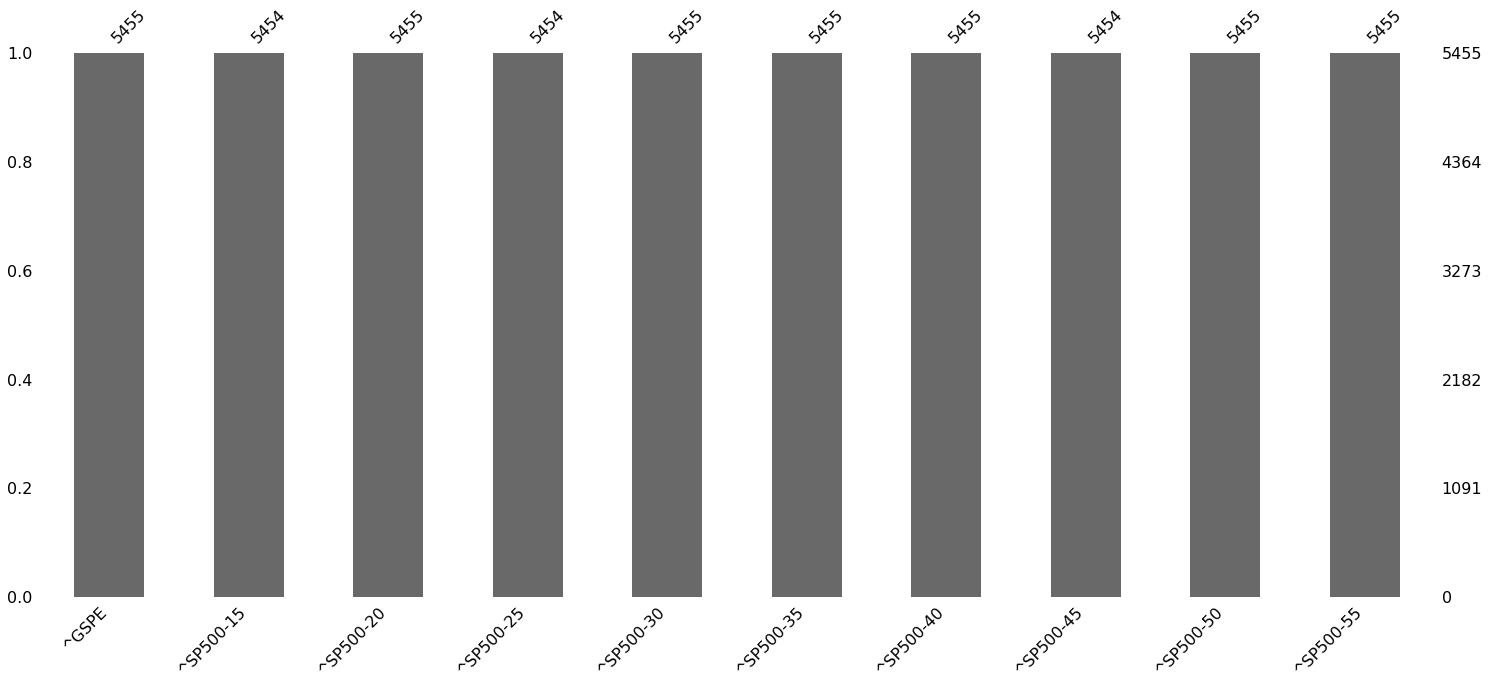

In [77]:
missingno.bar(sp500_sectors['Close'])

In [78]:
sp_500_sectors_close = pd.DataFrame(sp500_sectors['Close'])

In [79]:
sp_500_sectors_close.shape

(5455, 10)

### Persistencia de los datos

In [80]:
sp_500_sectors_close.to_csv('data/sp_500_sectors_close.csv',index = True)

### Obtención de retornos
Se obtienen los retornos porcentuales diarios

In [81]:
sp_500_sectors_returns = np.diff(sp_500_sectors_close, axis = 0)/sp_500_sectors_close.iloc[:-1,:]

In [83]:
sp_500_sectors_returns

,^GSPE,^SP500-15,^SP500-20,^SP500-25,^SP500-30,^SP500-35,^SP500-40,^SP500-45,^SP500-50,^SP500-55
Date,,,,,,,,,,
1995-01-03,0.003888,0.001506,0.000599,0.009734,-0.002794,0.001907,0.009945,0.003332,0.000100,0.006664
1995-01-04,0.000000,0.000401,0.003594,0.003280,-0.009307,0.000401,-0.000591,-0.002013,-0.001799,-0.004644
1995-01-05,-0.002582,0.010022,0.004079,-0.000297,-0.001515,-0.004806,0.002069,0.010588,-0.009211,0.002283
1995-01-06,-0.001394,0.003870,0.001288,-0.000495,0.000000,-0.006539,0.000983,0.007084,0.000707,-0.002080
1995-01-09,-0.003290,0.003361,0.003463,-0.004659,-0.001113,0.002025,0.002750,0.021599,-0.000606,0.000992
...,...,...,...,...,...,...,...,...,...,...
2016-08-23,-0.002694,-0.011588,-0.002842,-0.004454,-0.001604,-0.016074,-0.001236,-0.005358,-0.000347,0.000000
2016-08-24,-0.002916,0.004912,-0.000826,-0.003684,-0.004212,-0.007938,0.002816,0.001241,0.004110,0.000394
2016-08-25,-0.003392,-0.006061,-0.002813,-0.002704,-0.004696,0.003513,0.000617,0.001444,-0.010781,-0.021126


<AxesSubplot:xlabel='Date'>

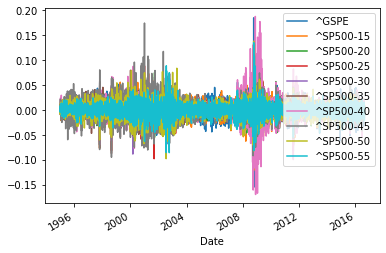

In [84]:
sp_500_sectors_returns.plot()

In [85]:
sp_500_sectors_returns.to_csv('data/sp_500_sectors_returns.csv')

## Multi Asset Dataset

Falta euro stoxx small cap

In [ ]:
multi_asset = ['^SPX', '^RUT', '^STOXX50E', '^FTSE', '^FTSC', ]
multi_asset_data = yf.download(selected_stocks,"1995-01-01","2016-08-31")

## S&P 500

### Descarga de la información
Siguiendo la metodología de Raffinot, primero se obtienen los activos que estaban en el índice en Diciembre del 2021, se obtiene la información histórica y posteriormente nos quedamos únicamente con aquellos activos que cuentan con historia suficiente (approx 3 años hacia atrás, es decir, 2018).

source: https://codingandfun.com/python-scraping-how-to-get-sp-500-companies-from-wikipedia/

A continuación se hace el web scraping de los componentes del S&P 500 a finales del 2021 en la versión de archivo de Wikipedia y mediante Beautifull Soup se obtienen los tickers correspondientes.

In [48]:
resp = requests.get('https://en.wikipedia.org/w/index.php?title=List_of_S%26P_500_companies&oldid=1062834329')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})


In [49]:
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)
tickers = list(map(lambda s: s.strip(), tickers))

En total se tienen 505 empresas, pues algunas de las empresas en el índice tienen más de una familia de acciones. 

In [50]:
len(tickers)

505

La nomenclatura utilizada en Wikipedia no es la misma que la de Yahoo Finance, por lo que hay que cambiar los puntos por guiones.

In [51]:
tickers[tickers.index('BRK.B')] = 'BRK-B'
tickers[tickers.index('BF.B')] = 'BF-B'

In [52]:
sp_500_2021 = yf.download(tickers, "2018-01-01", "2021-12-12")

[*********************100%***********************]  505 of 505 completed


In [62]:
sp_500_2021_close = sp_500_2021['Close']

### Análisis de Datos Faltantes

Mediante el uso de la librería *missingno* se grafica la matriz de datos faltantes, donde es posible observar que hay 8 activos con una cantidad importante de datos faltantes

<AxesSubplot:>

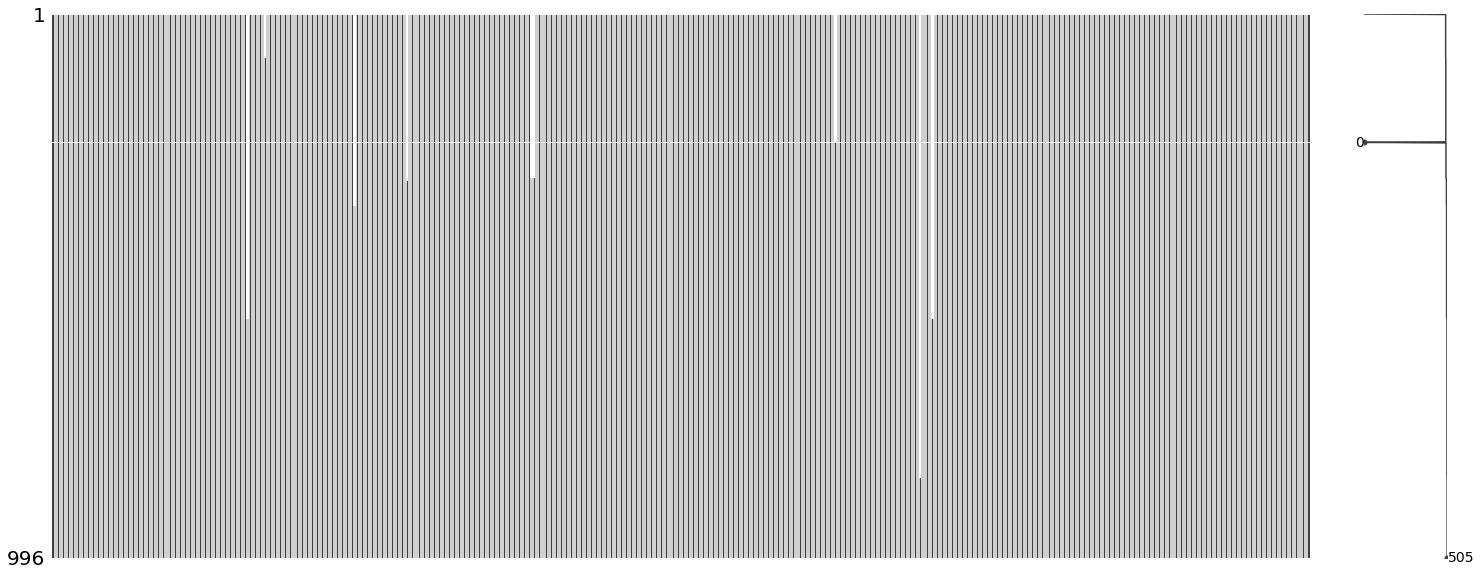

In [63]:
missingno.matrix(sp_500_2021_close)

Hay dos días en las que todas las acciones tienen valores faltantes, el primero de enero del 2018, pues era festivo, y el 05 de diciembre del 2018, pues ese día el NYSE no abrió debido a que fue el funeral del presidente bush (https://heavy.com/news/2018/12/stock-market-closed-national-day-of-mourning/), por lo que quito estos días del conjunto de datos.

In [60]:
sp_500_2021['Close']['ZTS'][pd.isnull(sp_500_2021['Close']['ZTS'])]

Date
2018-01-01   NaN
2018-12-05   NaN
Name: ZTS, dtype: float64

In [61]:
sp_500_2021['Close']['ZBRA'][pd.isnull(sp_500_2021['Close']['ZBRA'])]

Date
2018-01-01   NaN
2018-12-05   NaN
Name: ZBRA, dtype: float64

In [64]:
sp_500_2021_close.shape

(996, 505)

In [65]:
sp_500_2021_close.drop(['2018-01-01 ', '2018-12-05 '], inplace=True)

/tmp/ipykernel_27971/3182956591.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_500_2021_close.drop(['2018-01-01 ', '2018-12-05 '], inplace=True)


In [66]:
sp_500_2021_close.shape

(994, 505)

A continuación se muestra una gráfica del porcentaje de valores no faltantes por acción. Es posible observar que solo hay 8 acciones que tienen una cantidad importante de valores faltantes: OTIS, OGN, MRNA,FOXA, FOX, DOW, CTVA, CARR y CDAY. Estas accines se quitarán. 

<AxesSubplot:>

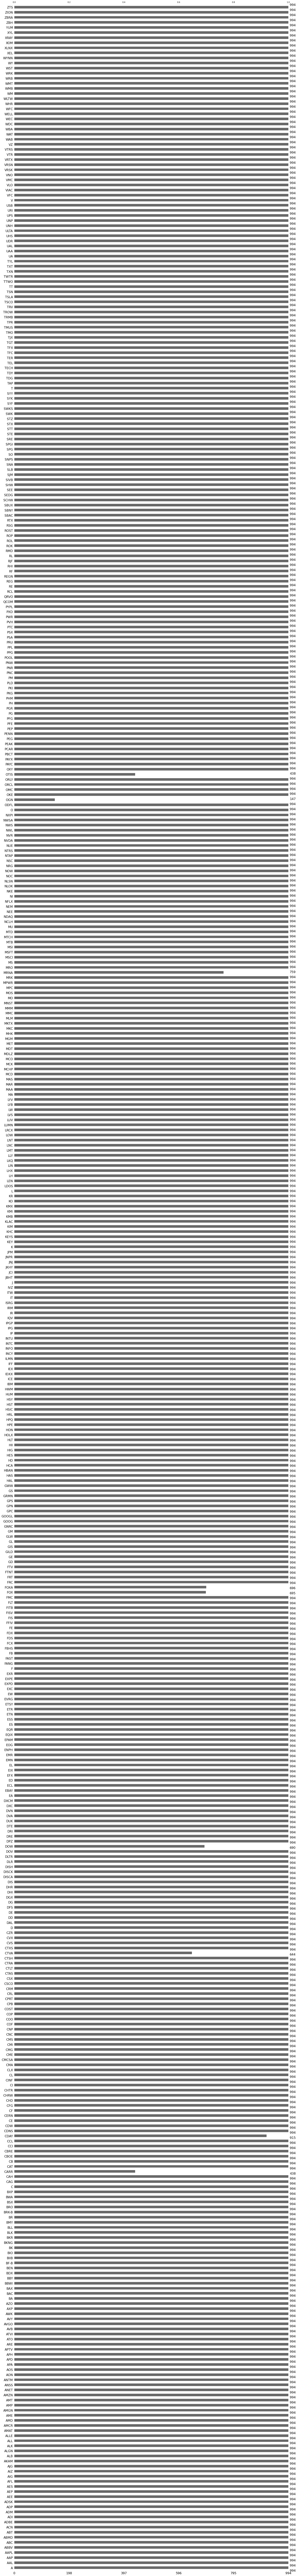

In [67]:
missingno.bar(sp_500_2021_close)

In [68]:
sp_500_2021_close.drop(columns = ['OTIS', 'OGN', 'MRNA', 'FOXA','FOX', 'DOW', 'CTVA', 'CARR', 'CDAY'], inplace=True)

/tmp/ipykernel_27971/3100078423.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_500_2021_close.drop(columns = ['OTIS', 'OGN', 'MRNA', 'FOXA','FOX', 'DOW', 'CTVA', 'CARR', 'CDAY'], inplace=True)


In [69]:
sp_500_2021_close.shape

(994, 496)

Se obtiene entonces un conjunto de datos "limpio" con **dimesiones $994 \times 496$**

### Persisitencia de Datos

Se guardan los precios de cierre ya limpios de las acciones con suficiente información histórica y sin valores faltantes en un csv para su posterior análisis.

In [71]:
sp_500_2021_close.to_csv('data/sp_500_2021_close.csv',index = True)